In [3]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [4]:
#Taking a forecasting dataset
dataset = pd.read_csv('train13519.csv')
np_array = dataset.iloc[:,:].values

### Adding derived parameters
These parameters will be fed to the multiple LSTM network to increase the forecasting capabilities. 

In [5]:
day_of_week = []
month = []
for i in range(len(np_array)):
    #Getting the day of week for detecting weekends
    day = datetime.datetime.strptime(np_array[i][0], '%Y-%m-%d %H:%M:%S').strftime('%a')
    day_of_week.append(day)  
    #Getting the month for vacation times
    mon = int(datetime.datetime.strptime(np_array[i][0], '%Y-%m-%d %H:%M:%S').strftime('%m'))
    month.append(mon)

In [6]:
dataset['day'] = day_of_week
dataset['month'] = month

In [7]:
rev_data = dataset.iloc[:,1:].values

### Scaling and encoding the data

In [8]:
#Importing the preprocessing libraries
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

In [9]:
#Converting categorical to numerical data
enc1 = LabelEncoder()
rev_data[:,1] = enc1.fit_transform(rev_data[:,1]) 

#Handeling categorical features
one_hot_encoder = OneHotEncoder(categorical_features=[1,2])
rev_data = one_hot_encoder.fit_transform(rev_data).toarray()

#Scaling the values
scl = MinMaxScaler()
rev_data[:,-1] = scl.fit_transform(rev_data[:,-1].reshape(-1,1)).reshape(-1)


In [10]:
rev_data.shape

(26496, 12)

In [11]:
#Creating X and Y dataset
X = rev_data[0:-1,:]
Y = rev_data[1:,-1]


#Creating test and train dataset
X = X.reshape(X.shape[0],1,X.shape[1])
X_train = X[:-25000,:]
Y_train = Y[:-25000]
X_test = X[25000:,:]
Y_test = Y[25000:]



In [12]:
#Displaying the converted dataset 
X

array([[[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.024]],

       [[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.096]],

       [[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.032]],

       ..., 
       [[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.072]],

       [[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.056]],

       [[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.104]]])

## Forecasting 
<br>
This will help us in finding the patters and using those, we can help in controlling the congestion in an area. For the forecasting, we will use LSTM cells which is most commonly used for NLP and time series analysis. It's a neural network based structure that has memory gates to store the previous patterns.
<br>
<img src="LSTM.jpeg">

In [12]:
#Importing neural nets libraries
import keras

Using TensorFlow backend.


In [14]:
#Creating the network structure
model = keras.models.Sequential()
model.add(keras.layers.LSTM(1024,input_shape=(X.shape[1], X.shape[2])))
model.add(keras.layers.Dense(1,activation = 'sigmoid'))
#Building the model
model.compile(optimizer='adam',loss = 'mae')

In [15]:
#Checking the summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1024)              4247552   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 4,248,577
Trainable params: 4,248,577
Non-trainable params: 0
_________________________________________________________________


In [34]:
#Training model (dont run this again)
model.fit(X,Y,20,10)

Epoch 1/10
26495/26495 [==============================] - 100s 4ms/step - loss: 0.0495
Epoch 2/10
26495/26495 [==============================] - 100s 4ms/step - loss: 0.0437
Epoch 3/10
26495/26495 [==============================] - 100s 4ms/step - loss: 0.0416
Epoch 4/10
26495/26495 [==============================] - 100s 4ms/step - loss: 0.0404
Epoch 5/10
26495/26495 [==============================] - 100s 4ms/step - loss: 0.0391
Epoch 6/10
26495/26495 [==============================] - 100s 4ms/step - loss: 0.0380
Epoch 7/10
26495/26495 [==============================] - 100s 4ms/step - loss: 0.0371
Epoch 8/10
26495/26495 [==============================] - 102s 4ms/step - loss: 0.0366
Epoch 9/10
26495/26495 [==============================] - 102s 4ms/step - loss: 0.0362
Epoch 10/10
26495/26495 [==============================] - 102s 4ms/step - loss: 0.0358


In [13]:
##Saving the model
json = model.to_json()
with open('Forecast_model.json','w') as f:
    f.write(json)
#Saving the weights
model.save_weights('model_weights.h5')

NameError: name 'model' is not defined

In [14]:
with open("Forecast_model.json",'r') as f:
    model = keras.models.model_from_json(f.read())
model.load_weights("model_weights.h5")

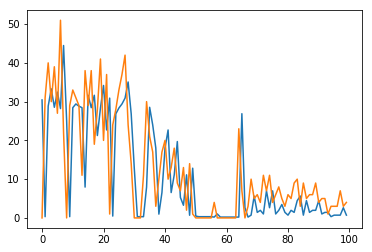

In [21]:
#Showing the forecast
plt.plot(scl.inverse_transform(model.predict(X_test))[:100])
plt.plot(scl.inverse_transform(Y_test.reshape(-1,1))[:100])
plt.show()

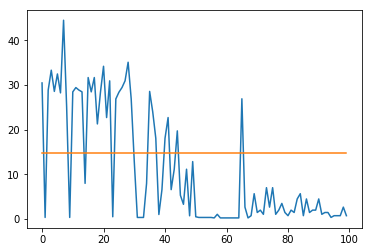

In [15]:
#Comparison with Mean -- Deviation from Ideal
plt.plot(scl.inverse_transform(model.predict(X_test))[:100])
plt.plot(scl.inverse_transform(np.array([Y.mean()]*100).reshape(-1, 1)))
plt.show()

### Model forecasting
Now, we can use the previous day data as seed to forecast the comming day traffic using the pattern learned from the seed

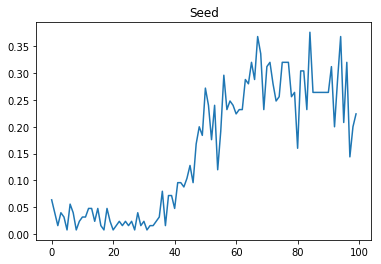

In [83]:
seed = X[900:1000]
fixed = X[-1][0]
plt.plot(Y[900:1000])
plt.title("Seed")
plt.show()

forecast = []
for i in range(100):
    fill = seed[:100]
    predict = model.predict(seed)
    predict = predict[-1]
    forecast.append(scl.inverse_transform([predict])[0][0])
    fixed = list(fixed)
    fixed.pop()
    fixed.append(predict[0])
    fixed = np.array([fixed])
    seed = list(seed)
    seed.append(fixed)
    fixed = X[-1][0]
    seed = np.array(seed)
    


## Business Pitch
<br>
<br>
<img src="Sc1.png">
<br>
<br>
<img src="Sc2.png">
<br>
<br>
<img src="Sc3.png">